<a href="https://colab.research.google.com/github/Francisroyce/Francisroyce/blob/main/Deep_learning_model_that_can_lip_read.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import Dependencies

In [40]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [41]:
# pip list

In [42]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio
from typing import List

In [43]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [44]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [45]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name:
    print("GPU device:", device_name)
else:
    print("CPU")


GPU device: /device:GPU:0


# Building Data Loading Functions

In [46]:
import gdown

In [47]:
# # downloading our data from an external google drive
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [48]:
# Creating a function to load videos
def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

This function, `load_video`, takes a path to a video file as input and returns a normalized representation of the video frames as a list of tensors.

Here's a breakdown of what the function does:

1. It imports the necessary libraries: `cv2` for video capture and `tensorflow` for image processing.
2. The function accepts a `path` parameter, which specifies the path to the video file to be loaded.
3. It initializes a video capture object `cap` using `cv2.VideoCapture(path)` to open the video file.
4. An empty list `frames` is created to store the processed video frames.
5. The function enters a loop that continues until there are no more frames to read (`cap.isOpened()`).
6. Within the loop, it reads each frame using `cap.read()`. The return value `ret` indicates whether the frame was successfully read.
7. If `ret` is `False`, it means there are no more frames to read, and the loop is terminated using `break`.
8. The current frame is converted to grayscale using `tf.image.rgb_to_grayscale(frame)`.
9. A specific region of interest (ROI) is extracted from the frame using indexing: `frame[190:236, 80:220, :]`. This ROI represents a rectangular portion of the frame defined by the specified coordinates.
10. The extracted ROI is appended to the `frames` list.
11. After all frames have been processed, the video capture object is released using `cap.release()` to free up system resources.
12. The list of frames is converted into a tensor using `tf.stack(frames)`. This results in a tensor with the shape `[num_frames, height, width, channels]`.
13. The mean value of the tensor is calculated using `tf.reduce_mean(frames)`.
14. The standard deviation of the tensor is calculated using `tf.math.reduce_std(frames)`.
15. The tensor is normalized by subtracting the mean and dividing by the standard deviation. This is achieved with `(frames - mean) / std`.
16. Finally, the normalized tensor is casted to `tf.float32` using `tf.cast(..., tf.float32)` and returned as the output of the function.

Overall, this function loads a video file, extracts specific regions of interest from each frame, calculates the mean and standard deviation of the frames, and returns the normalized frames as a tensor.

In [49]:
# vocabulary= words or letter we may encounter in data
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789"]
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [50]:
# converting characters to numbers and vice versa
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()}"
      f" (size = {char_to_num.vocabulary_size})")


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9'] (size = <bound method IndexLookup.vocabulary_size of <keras.layers.preprocessing.string_lookup.StringLookup object at 0x7feb50da6920>>)


This code uses the TensorFlow library to define and initialize two layers for mapping characters to numbers and vice versa. Here's a breakdown of what each line does:

1. `char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")`: This line creates a `StringLookup` layer named `char_to_num`. It takes two arguments: `vocabulary` and `oov_token`. The `vocabulary` parameter is set to `vocab`, which represents a list or set of characters or words that the layer will use for mapping. The `oov_token` parameter specifies the out-of-vocabulary token, which is an empty string (`""`) in this case. The `StringLookup` layer is responsible for converting characters/strings to numerical indices.

2. `num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)`: This line creates another `StringLookup` layer named `num_to_char`. It uses the `get_vocabulary()` method of `char_to_num` to retrieve the vocabulary learned by the previous layer. By setting `invert=True`, this layer will map numerical indices back to the original characters/strings.

3. `print(f"The vocabulary is: {char_to_num.get_vocabulary()}" f" (size = {char_to_num.vocabulary_size})")`: This line prints the vocabulary learned by the `char_to_num` layer, as well as its size. It uses f-string formatting to include the values in the string output.

Overall, this code sets up two layers for converting characters to numbers and vice versa, and then prints the vocabulary learned by the first layer.

In [51]:
# you can see it is converted to numbers
char_to_num(['a', 'b', 'c', 'd'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>

In [52]:
# number to char
num_to_char([1, 2, 3, 4])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'b', b'c', b'd'], dtype=object)>

In [53]:
# Loading alignments function
def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens.extend([' ', line[2]])
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


This code appears to load alignments from a file and convert them into a numerical representation. Let's break it down step by step:

1. The function `load_alignments` takes a parameter `path`, which is the path to the file containing alignments, and it returns a list of strings.

2. It opens the file specified by `path` using the `open()` function, in read mode ('r'), and assigns the file object to the variable `f`.

3. It reads all the lines from the file using the `readlines()` method of the file object `f`, and assigns the resulting list of lines to the variable `lines`.

4. It initializes an empty list called `tokens` to store the alignment tokens.

5. It iterates over each line in the `lines` list using a for loop.

6. Inside the loop, it splits the line into a list of words using the `split()` method, and assigns it to the variable `line`.

7. It checks if the third element (`line[2]`) of the `line` list is not equal to the string 'sil'.

8. If the condition is true, it appends the third element (`line[2]`) to the `tokens` list using the list concatenation operator `[*tokens, ' ', line[2]]`. The ' ' is added as a space separator between tokens.

9. Finally, it converts the `tokens` list into a numerical representation. It reshapes the list into a tensor using `tf.reshape()`, then splits the strings into Unicode characters using `tf.strings.unicode_split()`, and converts the characters into numerical values using `char_to_num()`.

10. The resulting numerical representation of the tokens is returned as the output of the function.

In [54]:
import os
# load data function
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('/content/drive/MyDrive/data/s1', f'{file_name}.mpg')
    alignment_path = os.path.join('/content/drive/MyDrive/data/alignments/s1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


The function load_data takes a single argument path, which is expected to be a string.

The path argument is converted from a numpy array to a regular string using the bytes.decode() method.

The code then extracts the file name from the path string by splitting it using the backslash (\) as the delimiter. It takes the last element of the resulting list, which should be the file name, and removes the file extension by splitting it again using the dot (.) as the delimiter. It takes the first element of this new list, which should be the file name without the extension. The resulting file name is stored in the file_name variable.

The video_path variable is created by joining the strings 'data', 's1', and the file_name with the .mpg extension. This suggests that the code is constructing a file path to load a video file from a specific directory.

The alignment_path variable is created by joining the strings 'data', 'alignment', 's1', and the file_name with the .align extension. This suggests that the code is constructing a file path to load alignment data from a specific directory.

The code calls two unspecified functions, load_video() and load_alignments(), passing in the video_path and alignment_path respectively. These functions are expected to load video frames and alignment data, but their implementations are not shown in the provided code snippet.

The function returns the loaded frames and alignments as a tuple.

In [55]:
test_path = '/content/drive/MyDrive/data/s1/bbaf2n.mpg'

In [56]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf2n'

In [57]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[1.4991663 ],
          [1.4991663 ],
          [1.4616871 ],
          ...,
          [0.41227072],
          [0.41227072],
          [0.41227072]],
 
         [[1.4991663 ],
          [1.4991663 ],
          [1.4616871 ],
          ...,
          [0.41227072],
          [0.41227072],
          [0.41227072]],
 
         [[1.4616871 ],
          [1.4616871 ],
          [1.4991663 ],
          ...,
          [0.3373124 ],
          [0.3373124 ],
          [0.3373124 ]],
 
         ...,
 
         [[1.0494163 ],
          [1.0494163 ],
          [1.0119373 ],
          ...,
          [0.11243746],
          [0.11243746],
          [0.07495831]],
 
         [[1.0494163 ],
          [1.0494163 ],
          [1.0119373 ],
          ...,
          [0.11243746],
          [0.07495831],
          [0.07495831]],
 
         [[1.0494163 ],
          [1.0494163 ],
          [1.0119373 ],
          ...,
          [0.07495831],
    

In [58]:
frames , alignments = load_data(tf.convert_to_tensor(test_path))

In [59]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4616871 ],
         [1.4616871 ],
         [1.4991663 ],
         ...,
         [0.3373124 ],
         [0.3373124 ],
         [0.3373124 ]],

        ...,

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.11243746],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.07495831],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.07495831],
         [0.07495831],
         [0.03747915]]],


  

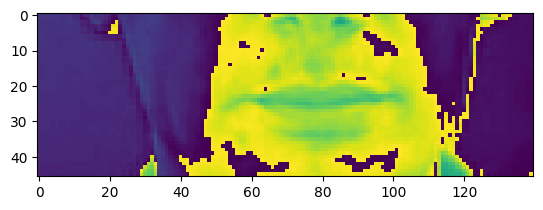

In [60]:
plt.imshow(frames[70]);
# showing lips from the videos

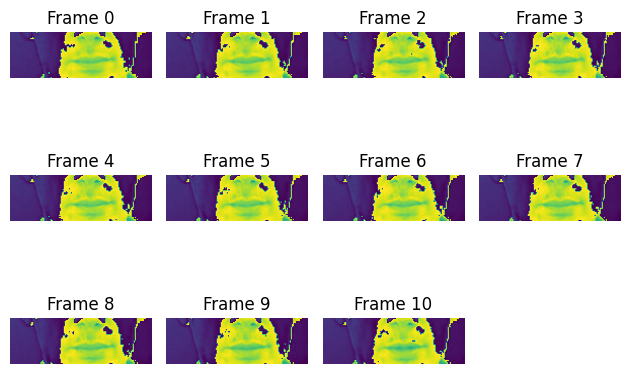

In [61]:
# Plot frames from 0 to 10
for i in range(11):  # Range from 0 to 10 (inclusive)
    plt.subplot(3, 4, i+1)  # Creating a 3x4 grid of subplots, adjust the dimensions as needed
    plt.imshow(frames[i])
    plt.title(f'Frame {i}')
    plt.axis('off')  # Turn off the axis labels

plt.tight_layout()  # Adjust spacing between subplots if needed
plt.show()

# this frame is showing different lips

In [62]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14,  0,  2, 12, 21,  5,  0,  1, 20,  0,  6,  0, 20, 23, 15,
        0, 14, 15, 23])>

In [63]:
num_to_char(alignments)

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b'', b'b', b'l', b'u', b'e', b'', b'a', b't',
       b'', b'f', b'', b't', b'w', b'o', b'', b'n', b'o', b'w'],
      dtype=object)>

In [64]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', '', 'b', 'l', 'u', 'e', '', 'a', 't', '', 'f', '', 't', 'w', 'o', '', 'n', 'o', 'w']


In [65]:
# tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

In [66]:
import nltk

# Download the necessary resources (only required for the first time)
nltk.download('punkt')

aligned_string = tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

aligned_string_str = aligned_string.numpy().decode()

words = nltk.word_tokenize(aligned_string_str)

for word in words:
    print(word)


binblueatftwonow


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [67]:
# mapple function
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result



The mapple_function passes the path argument to the load_data function using tf.py_function, which wraps the load_data function and ensures it can be executed within TensorFlow's graph. It specifies that the expected output types are tf.float32 and tf.float64.

The result of tf.py_function is stored in the result variable and then returned as the output of the mapple_function. Since the result is returned as a list of strings (List[str]), it suggests that the load_data function may convert the processed data into string format before returning it.

To fully understand the functionality of this code, you would need to examine the implementation of the load_data function and any related functions or modules it depends on.







# Create Data Pipeline

In [68]:
data = tf.data.Dataset.list_files('./drive/MyDrive/data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [69]:
frames, alignments = data.as_numpy_iterator().next()

In [70]:
frames

array([[[[[10.342452  ],
          [10.342452  ],
          [10.342452  ],
          ...,
          [10.342452  ],
          [10.342452  ],
          [10.342452  ]],

         [[10.342452  ],
          [10.342452  ],
          [10.342452  ],
          ...,
          [10.342452  ],
          [10.342452  ],
          [10.342452  ]],

         [[10.342452  ],
          [10.342452  ],
          [10.342452  ],
          ...,
          [10.342452  ],
          [10.342452  ],
          [10.342452  ]],

         ...,

         [[10.342452  ],
          [10.342452  ],
          [10.342452  ],
          ...,
          [10.342452  ],
          [10.342452  ],
          [10.342452  ]],

         [[10.342452  ],
          [10.342452  ],
          [10.342452  ],
          ...,
          [10.342452  ],
          [10.342452  ],
          [10.342452  ]],

         [[10.342452  ],
          [10.342452  ],
          [10.342452  ],
          ...,
          [10.342452  ],
          [10.342452  ],
          

In [71]:
len(frames)

2

In [72]:
alignments

array([[16, 12,  1,  3,  5,  0,  2, 12, 21,  5,  0, 23,  9, 20,  8,  0,
        24,  0, 15, 14,  5,  0, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14,  0, 18,  5,  4,  0,  2, 25,  0, 20,  0, 26,  5, 18,
        15,  0, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [73]:
test = data.as_numpy_iterator()

In [74]:
test

In [75]:
val = test.next(); val[0]

array([[[[[ 1.4617805 ],
          [ 1.4617805 ],
          [ 1.422273  ],
          ...,
          [ 0.11852275],
          [ 0.15803033],
          [ 0.15803033]],

         [[ 1.4617805 ],
          [ 1.4617805 ],
          [ 1.422273  ],
          ...,
          [ 0.11852275],
          [ 0.15803033],
          [ 0.15803033]],

         [[ 1.3432579 ],
          [ 1.3432579 ],
          [ 1.3432579 ],
          ...,
          [ 0.07901517],
          [ 0.03950758],
          [ 0.03950758]],

         ...,

         [[ 0.948182  ],
          [ 0.948182  ],
          [ 0.948182  ],
          ...,
          [ 9.876896  ],
          [ 9.837388  ],
          [ 9.837388  ]],

         [[ 0.948182  ],
          [ 0.948182  ],
          [ 0.948182  ],
          ...,
          [ 9.837388  ],
          [ 9.837388  ],
          [ 9.837388  ]],

         [[ 0.948182  ],
          [ 0.948182  ],
          [ 0.948182  ],
          ...,
          [ 9.837388  ],
          [ 9.837388  ],
          

In [76]:
imageio.mimsave('./animate.gif', val[0][1], fps=10)

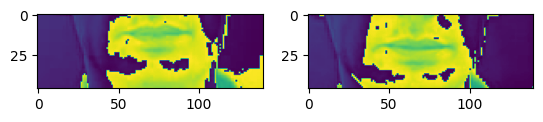

In [77]:
fig, axs = plt.subplots(1, 2)  # Create a figure with 1 row and 2 columns
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
axs[0].imshow(val[0][0][0])  # Display the first image in the first subplot
axs[1].imshow(val[0][1][50])  # Display the second image in the second subplot

plt.show()

In [78]:
tf.strings.reduce_join([num_to_char(word) + ' ' for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'l a y  w h i t e  a t  l  f i v e  a g a i n                '>

# Design the deep neural network

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In the code i provided, the use of 3D layers indicates that the video project involves working with three-dimensional data. In particular, the model is built using the TensorFlow Keras library, and it includes various 3D layers such as Conv3D, MaxPool3D, and SpatialDropout3D.

Video data is often represented in the form of multiple frames, where each frame contains a two-dimensional image. However, in order to capture temporal information and learn spatiotemporal patterns in videos, it is necessary to consider the three-dimensional nature of the data.

The Conv3D layer, for example, performs three-dimensional convolution, taking into account both spatial and temporal dimensions. It allows the model to capture spatial patterns within each frame and also learn temporal dependencies between consecutive frames.

Other 3D layers, such as MaxPool3D and SpatialDropout3D, operate similarly to their 2D counterparts but extend their functionality to the third dimension. MaxPool3D performs three-dimensional max pooling, reducing the spatial dimensions while maintaining the temporal dimension. SpatialDropout3D applies dropout regularization specifically in the spatial dimensions, helping prevent overfitting and improving generalization.

By utilizing these 3D layers, the model can effectively process and analyze video data, capturing both spatial and temporal features, which is crucial for many video-related tasks such as action recognition, video classification, and video segmentation.

In [87]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [88]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

This code defines a sequential model for deep learning using the Keras library. Let's go through it step by step:

1. `model = Sequential()`: This creates a sequential model object, which allows us to build a neural network by stacking layers on top of each other.

2. `model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))`: This adds a 3D convolutional layer with 128 filters, a filter size of 3x3x3, and a padding mode of 'same'. The input shape of the layer is (75, 46, 140, 1), indicating a 5D input tensor with dimensions (batch_size, depth, height, width, channels). The layer applies the convolution operation to the input, extracting spatial features.

3. `model.add(Activation('relu'))`: This adds a ReLU activation function to introduce non-linearity after the convolutional layer.

4. `model.add(MaxPool3D((1,2,2)))`: This adds a 3D max pooling layer with a pool size of (1, 2, 2). Max pooling reduces the spatial dimensions of the input, retaining the maximum value within each pooling window.

5. The next few lines (steps 2-4) add additional convolutional, activation, and max pooling layers, with different filter sizes and numbers of filters. This helps in extracting more complex features from the input data.

6. `model.add(TimeDistributed(Flatten()))`: This layer applies the Flatten operation across the temporal dimension of the input. It converts the input from a 3D tensor to a 2D tensor, preparing it for the recurrent layers that follow.

7. `model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))`: This adds a bidirectional LSTM layer with 128 units. Bidirectional LSTMs process the input sequence in both directions, capturing information from past and future time steps. The `return_sequences=True` parameter ensures that the layer returns sequences rather than a single output.

8. `model.add(Dropout(.5))`: This adds a dropout layer that randomly sets 50% of the input units to 0 at each training step. Dropout helps in preventing overfitting by reducing the reliance of the model on specific features.

9. The previous two lines (steps 7-8) are repeated to add another bidirectional LSTM layer with dropout.

10. `model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))`: This adds a fully connected (dense) layer with a number of units equal to the vocabulary size plus 1. The 'he_normal' kernel initializer is used to initialize the weights of the layer. The activation function is set to 'softmax', which converts the output into a probability distribution over the classes. This layer is responsible for the final classification of the input data.

Overall, this model architecture consists of convolutional layers for feature extraction, followed by recurrent layers (bidirectional LSTMs) for sequence processing, and a final dense layer for classification.

In [89]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [90]:
# testing out before i continue

ywhat = model.predict(val[0])

1/1 [==============================] - 8s 8s/step


In [91]:
# checking the result of the prediction
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in ywhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'nnnssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssww'>

Let's break down the code step by step:

1. `ywhat = model.predict(val[0])`: This line is making a prediction using a machine learning model called `model`. The input for the prediction is `val[0]`, which is presumably a data point or a batch of data points. The result of the prediction is stored in the variable `ywhat`.

2. `tf.strings.reduce_join(...)`: This line uses TensorFlow's `reduce_join` function from the `tf.strings` module. This function concatenates a list of strings into a single string. It takes a list comprehension as an argument, which processes each element `x` in the provided list.

3. `[num_to_char(tf.argmax(x)) for x in ywhat[1]]`: This list comprehension is iterating over the elements in `ywhat[1]`, which suggests that `ywhat` is a list or an array-like object. For each element `x`, it calls a function `num_to_char` and passes the result of `tf.argmax(x)` as an argument. The `tf.argmax` function returns the index of the maximum value in `x`, which is likely a one-hot encoded representation of characters or tokens. The `num_to_char` function presumably converts the index back to its corresponding character or token representation.

Overall, the code is making predictions using a machine learning model and converting the predicted values into a string representation using TensorFlow operations.

In [93]:
ywhat[0]

array([[0.02349688, 0.02659395, 0.02212984, ..., 0.02120561, 0.02753587,
        0.0279835 ],
       [0.02449556, 0.02555994, 0.02228467, ..., 0.02184256, 0.02743618,
        0.02823115],
       [0.02544247, 0.02482711, 0.02236077, ..., 0.02232022, 0.02768666,
        0.02818198],
       ...,
       [0.03593339, 0.02188426, 0.02414579, ..., 0.02653934, 0.02794538,
        0.02376185],
       [0.03512984, 0.02218973, 0.02478153, ..., 0.02742339, 0.02828437,
        0.02377104],
       [0.03383873, 0.02274722, 0.02543032, ..., 0.02847065, 0.02898032,
        0.02405858]], dtype=float32)

In [94]:
ywhat[0].shape

(75, 40)

In [96]:
tf.argmax(ywhat[0], axis = 1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([22, 14, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19])>

In [97]:
model.input_shape

(None, 75, 46, 140, 1)

In [98]:
model.output_shape

(None, 75, 40)